This notebook takes borehole data from the East Kimberley and uses it to calculate the cementation values for solving Archie's Law.

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [4]:
from sqlite3 import dbapi2 as sqlite
import pandas as pd
from shapely.geometry import Polygon, shape
from shapely import wkt
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
from geophys_utils._netcdf_line_utils import NetCDFLineUtils
from geophys_utils import points2convex_hull
import matplotlib.pyplot as plt
import os
import math
import sqlalchemy as db
from sqlalchemy import create_engine, event
import netCDF4
import yaml
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
from hydrogeol_utils.db_utils import makeCon, closeCon

In [5]:
# Function for finding the nearest point 

def get_bore(df, borehole_id):
    """
    df: dataframe with borehole data
    borehole_id: eno
    
    returns
    dataframe with only rows corresponding to particular bore
    """
    mask = df['borehole_id'] == borehole_id
    return df[mask]


In [6]:
# Bring in the AEM

nc_dir = r"C:\Users\PCUser\Desktop\EK_data\AEM\netCDF"

cond_path = os.path.join(nc_dir,'EastKimberley_wb_inversion.nc')
cond_dataset = netCDF4.Dataset(cond_path, 'r')

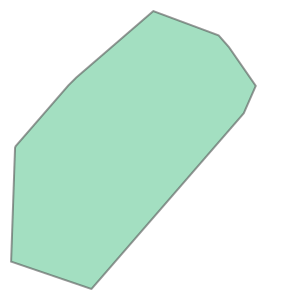

In [7]:
# Create a convex hull around the Keep River area based on line 3xxx,xxx

# Initialise an instance of the netCDF point and line utility classes
cond_line_utils = NetCDFLineUtils(cond_dataset)
cond_point_utils = NetCDFPointUtils(cond_dataset)

# Display the lines for the conductivity mode

lines = cond_line_utils.line

# Get the utm coordinates using the mask created above
utm_wkt, aem_coords = cond_point_utils.utm_coords(cond_point_utils.xycoords)

# Get the convex hull of the subset
convex_hull = points2convex_hull(aem_coords)


# Create a shapely object of the convex hull
Keep_poly = Polygon(convex_hull)

Keep_poly

In [8]:
# Extract data from the database

# Extract borehole data from the database

DB_PATH = r"C:\Users\PCUser\Desktop\EK_data\Boreholes\East_Kimberley_borehole_data.sqlite"

SPATIALITE_PATH = r'C:\mod_spatialite-NG-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)


connection = makeCon(DB_PATH)



Connected to C:\Users\PCUser\Desktop\EK_data\Boreholes\East_Kimberley_borehole_data.sqlite. Temporary working copy created.


In [9]:
# Extract boreholes from within this geometry

df_header = borehole_utils.extract_boreholes_within_geometry('borehole', connection,
                                                             Keep_poly.wkt, columns = 'all',
                                                             verbose = True)
# Keep only bores with both EC and induction

mask = np.logical_and(df_header['Induction_acquired'] == 1,  df_header['EC_pH_acquired'] == 1)

df_header= df_header[mask]

# Get the enos



enos= df_header['borehole_id'].values


Select b.* from borehole b  where within(b.geom,GeomFromText('POLYGON ((497703.0000000027 8246242.49994433, 497669.0000000026 8246242.99994433, 497635.8125000035 8246246.49994433, 497603.4062500036 8246253.999944331, 496786.3125000036 8246526.499944339, 464605.5000000424 8257490.999944661, 466221.6875000397 8304389.499946042, 466469.6875000387 8305081.999946062, 488233.6875000138 8330164.999946804, 491461.4062500101 8333382.4999469, 523230.3124999756 8360782.999947714, 550185.3749999455 8350756.499947417, 554398.812499941 8345955.999947274, 565480.3749999278 8329967.999946802, 565481.374999927 8329943.4999468, 560532.9999999315 8318658.499946466, 497768.9062499999 8246255.499944331, 497736.5937500015 8246246.49994433, 497703.0000000027 8246242.49994433))'));


In [10]:
# First import all the datasets based on our enos (primary key)

df_ind = borehole_utils.extract_sql_with_primary_key("induction_gamma_data", 
                                                        ['Depth', 'Apparent_conductivity','borehole_id'],
                                                        connection, enos,
                                                       verbose = True).dropna(how='any')

df_EC = borehole_utils.extract_sql_with_primary_key("pore_fluid_EC_pH", 
                                                       ['Depth', 'EC', 'borehole_id'],
                                                       connection, enos, verbose = True)


select t.Depth, t.Apparent_conductivity, t.borehole_id from induction_gamma_data t where t.borehole_id in (635728,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635744,635921);
select t.Depth, t.EC, t.borehole_id from pore_fluid_EC_pH t where t.borehole_id in (635728,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635744,635921);


In [11]:
# For every EC we will search for the representative induction value

df_EC_cond = pd.DataFrame(columns = ['Depth','Apparent_conductivity', 'EC', 'borehole_id'])

max_distance = 2.

# Iterate through bores
for bore in df_EC['borehole_id'].unique():
    df_EC_subset = get_bore(df_EC, bore)
    df_ind_subset = get_bore(df_ind, bore)

    # Iterate throught the depths and find the nearest conductivity
    inds = df_ind_subset.Apparent_conductivity.values
    inds_interpolated = np.nan*np.zeros(shape = len(df_EC_subset),
                                        dtype = np.float32)
    
    # Iterate through the EC sample depths
    for i, depth in enumerate(df_EC_subset.Depth.values):
        
        # Define minimum indices
        min_ind = np.argmin(np.abs(df_ind_subset.Depth.values - depth))
        
        # Check if the nearest point is within the maximum distance
        
        if not np.abs(df_ind_subset.Depth.values - depth)[min_ind] > max_distance:
        
            inds_interpolated[i] = inds[min_ind]
        else:
            print(np.abs(df_ind_subset.Depth.values - depth)[min_ind])
    
    # Add to dataframe
    df_EC_subset['Apparent_conductivity'] = inds_interpolated
    
    
    
    # Append 
    df_EC_cond = df_EC_cond.append(df_EC_subset)
        
        
df_EC_cond.dropna(how='any', axis = 0, inplace=True)       

2.646000000000001
2.8859999999999957
3.0760000000000005
3.3859999999999957
3.6059999999999945
3.355000000000004
3.6910000000000025
2.030000000000001


C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [12]:
df_EC_cond

,Apparent_conductivity,Depth,EC,borehole_id
0,0.750119,4.20,1.5870,635728
1,0.683254,4.54,1.4620,635728
2,0.681730,4.88,1.2970,635728
3,1.228420,6.18,2.0450,635728
4,1.471350,6.64,2.1500,635728
...,...,...,...,...
651,0.730638,31.92,0.5420,635742
652,0.602245,32.77,0.4210,635742
653,0.458843,33.39,0.3912,635742
654,0.414987,33.73,0.3798,635742


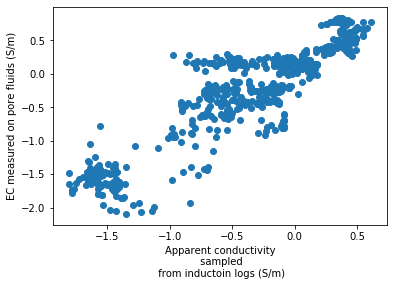

In [13]:
# Scatter plot the EC and apparent conductivity


plt.scatter(np.log10(df_EC_cond['Apparent_conductivity'].values),
           np.log10(df_EC_cond['EC']).values)
           #c = df_EC_cond['Depth'].values,
           #colormap='viridis')

plt.xlabel('Apparent conductivity\n sampled\n from inductoin logs (S/m)')

plt.ylabel('EC measured on pore fluids (S/m)')

plt.savefig(r'C:\Temp\EK_EC_apparent_conductivity.png', dpi = 300)
plt.show()

In [14]:
# We try the same exercise using the AEM bulk conductivity

cond_point_utils = NetCDFPointUtils(cond_dataset)

utm_wkt, aem_coords = cond_point_utils.utm_coords(cond_point_utils.xycoords)

# Extract the AEM conductivity using nearest neighbour
distances, indices = spatial_functions.nearest_neighbours(df_header[['Easting','Northing']],
                                                          aem_coords,
                                                          points_required = 1,# return 10 closest points
                                                          max_distance = 250.)

In [15]:
conductivity_profile = cond_dataset['conductivity'][indices]

depth_tops = cond_dataset['layer_top_depth'][indices]

depth_bottom = np.nan*np.ones(depth_tops.shape, dtype = np.float32)

depth_bottom[:,:-1] = depth_tops[:,1:]

east = cond_dataset['easting'][indices]
north = cond_dataset['northing'][indices]
doi = cond_dataset['depth_of_investigation'][indices]

In [16]:
# Create an AEM dataframe

df_AEM = pd.DataFrame(columns = ['Depth_from', 'Depth_to',
                                 'conductivity', 'easting',
                                 'northing', 'borehole_id', 'EC',
                                 'doi'])

df_AEM['conductivity'] = conductivity_profile.flatten()
df_AEM['Depth_from'] = depth_tops.flatten()
df_AEM['Depth_to'] = depth_bottom.flatten()

df_AEM['easting'] = np.repeat(east, conductivity_profile.shape[1])
df_AEM['northing'] = np.repeat(north, conductivity_profile.shape[1])

df_AEM['doi'] = np.repeat(doi, conductivity_profile.shape[1])

df_AEM['borehole_id'] = np.repeat(df_header['borehole_id'].values,
                                   conductivity_profile.shape[1])

In [17]:
mask = df_AEM['doi'] > df_AEM['Depth_from']

In [18]:
df_AEM = df_AEM[mask]

In [19]:
df_AEM

,Depth_from,Depth_to,conductivity,easting,northing,borehole_id,EC,doi
0,0.000000,3.000000,0.178667,520112.68750,8306273.5,635728,NaN,89.919998
1,3.000000,6.300000,0.290192,520112.68750,8306273.5,635728,NaN,89.919998
2,6.300000,10.000000,0.848896,520112.68750,8306273.5,635728,NaN,89.919998
3,10.000000,14.100000,0.671141,520112.68750,8306273.5,635728,NaN,89.919998
4,14.100000,18.600000,0.712758,520112.68750,8306273.5,635728,NaN,89.919998
...,...,...,...,...,...,...,...,...
369,41.900002,49.299999,0.791139,523360.09375,8314916.5,635921,NaN,80.870003
370,49.299999,57.500000,0.737463,523360.09375,8314916.5,635921,NaN,80.870003
371,57.500000,66.599998,0.624220,523360.09375,8314916.5,635921,NaN,80.870003
372,66.599998,76.699997,0.526039,523360.09375,8314916.5,635921,NaN,80.870003


In [20]:
# Now we iterate through each column and find the average

for bore in df_AEM['borehole_id'].unique():
    
    df_EC_subset = get_bore(df_EC, bore)
    
    df_AEM_subset = get_bore(df_AEM, bore)
    
    new_intervals = df_AEM_subset[['Depth_from', 'Depth_to']]
    
    
    df_newEC = spatial_functions.interpolate_depths_to_intervals(df_EC_subset, ['EC'],
                                                                 new_intervals.values,
                                                                depth_column='Depth', how='median')

    df_AEM_subset['EC'] = df_newEC['EC'].values
    
    df_AEM.at[df_AEM_subset.index, :] = df_AEM_subset
    
    
df_AEM.dropna(how = 'any', subset = ['EC'], inplace=True)

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [23]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(df_AEM['conductivity'].values),
                                                               np.log10(df_AEM['EC'].astype(np.float).values))

R-squared =  0.8674041106281604
EC =  0.9060561444524374  * sigma +  0.4937600070627951
p-value =  3.5991674671326844e-38
Standard error is  0.03888394821367266


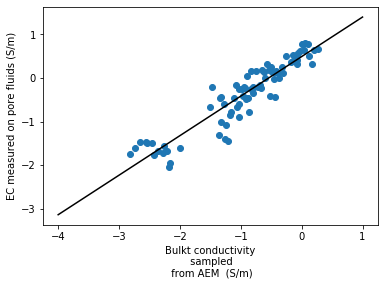

In [25]:
# Scatter plot the EC and apparent conductivity

x = np.array([-4,1])
y = slope * x + intercept
        
plt.plot(x, y, 'k')

plt.scatter(np.log10(df_AEM['conductivity'].values),
           np.log10(df_AEM['EC'].astype(np.float).values))
           #c = df_EC_cond['Depth'].values,
           #colormap='viridis')
print('R-squared = ', str(r_value**2))
print('EC = ', str(slope), ' * sigma + ', str(intercept) )
print('p-value = ', p_value)
print('Standard error is ', std_err)        
plt.xlabel('Bulkt conductivity\n sampled\n from AEM  (S/m)')

plt.ylabel('EC measured on pore fluids (S/m)')

plt.savefig(r'C:\Temp\EK_EC_AEM_conductivity.png', dpi = 300)
plt.show()

In [23]:
cz_base_src = rasterio.open(infile)
cz_base_arr = cz_base_src.read()[0]

(68,)

In [25]:
slope


0.809932865164502